In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('check')

check


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Generate data paths with labels
train_data_dir = './drive/MyDrive/Colab Notebooks/data/train'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
# Generate data paths with labels
test_data_dir = './drive/MyDrive/Colab Notebooks/data/test'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
train_df

,filepaths,labels
0,./drive/MyDrive/Colab Notebooks/data/train/Non...,NonDemented
1,./drive/MyDrive/Colab Notebooks/data/train/Non...,NonDemented
2,./drive/MyDrive/Colab Notebooks/data/train/Non...,NonDemented
3,./drive/MyDrive/Colab Notebooks/data/train/Non...,NonDemented
4,./drive/MyDrive/Colab Notebooks/data/train/Non...,NonDemented
...,...,...
5116,./drive/MyDrive/Colab Notebooks/data/train/Ver...,VeryMildDemented
5117,./drive/MyDrive/Colab Notebooks/data/train/Ver...,VeryMildDemented
5118,./drive/MyDrive/Colab Notebooks/data/train/Ver...,VeryMildDemented
5119,./drive/MyDrive/Colab Notebooks/data/train/Ver...,VeryMildDemented


In [ ]:
ts_df

,filepaths,labels
0,./drive/MyDrive/Colab Notebooks/data/test/Mode...,ModerateDemented
1,./drive/MyDrive/Colab Notebooks/data/test/Mode...,ModerateDemented
2,./drive/MyDrive/Colab Notebooks/data/test/Mode...,ModerateDemented
3,./drive/MyDrive/Colab Notebooks/data/test/Mode...,ModerateDemented
4,./drive/MyDrive/Colab Notebooks/data/test/Mode...,ModerateDemented
...,...,...
1274,./drive/MyDrive/Colab Notebooks/data/test/NonD...,NonDemented
1275,./drive/MyDrive/Colab Notebooks/data/test/NonD...,NonDemented
1276,./drive/MyDrive/Colab Notebooks/data/test/NonD...,NonDemented
1277,./drive/MyDrive/Colab Notebooks/data/test/NonD...,NonDemented


In [ ]:
valid_df, test_df = train_test_split(ts_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rotation_range=30,
                            rescale=1./255,
                            shear_range=0.2,
                            zoom_range=0.2,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest'
)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5121 validated image filenames belonging to 4 classes.
Found 767 validated image filenames belonging to 4 classes.
Found 512 validated image filenames belonging to 4 classes.


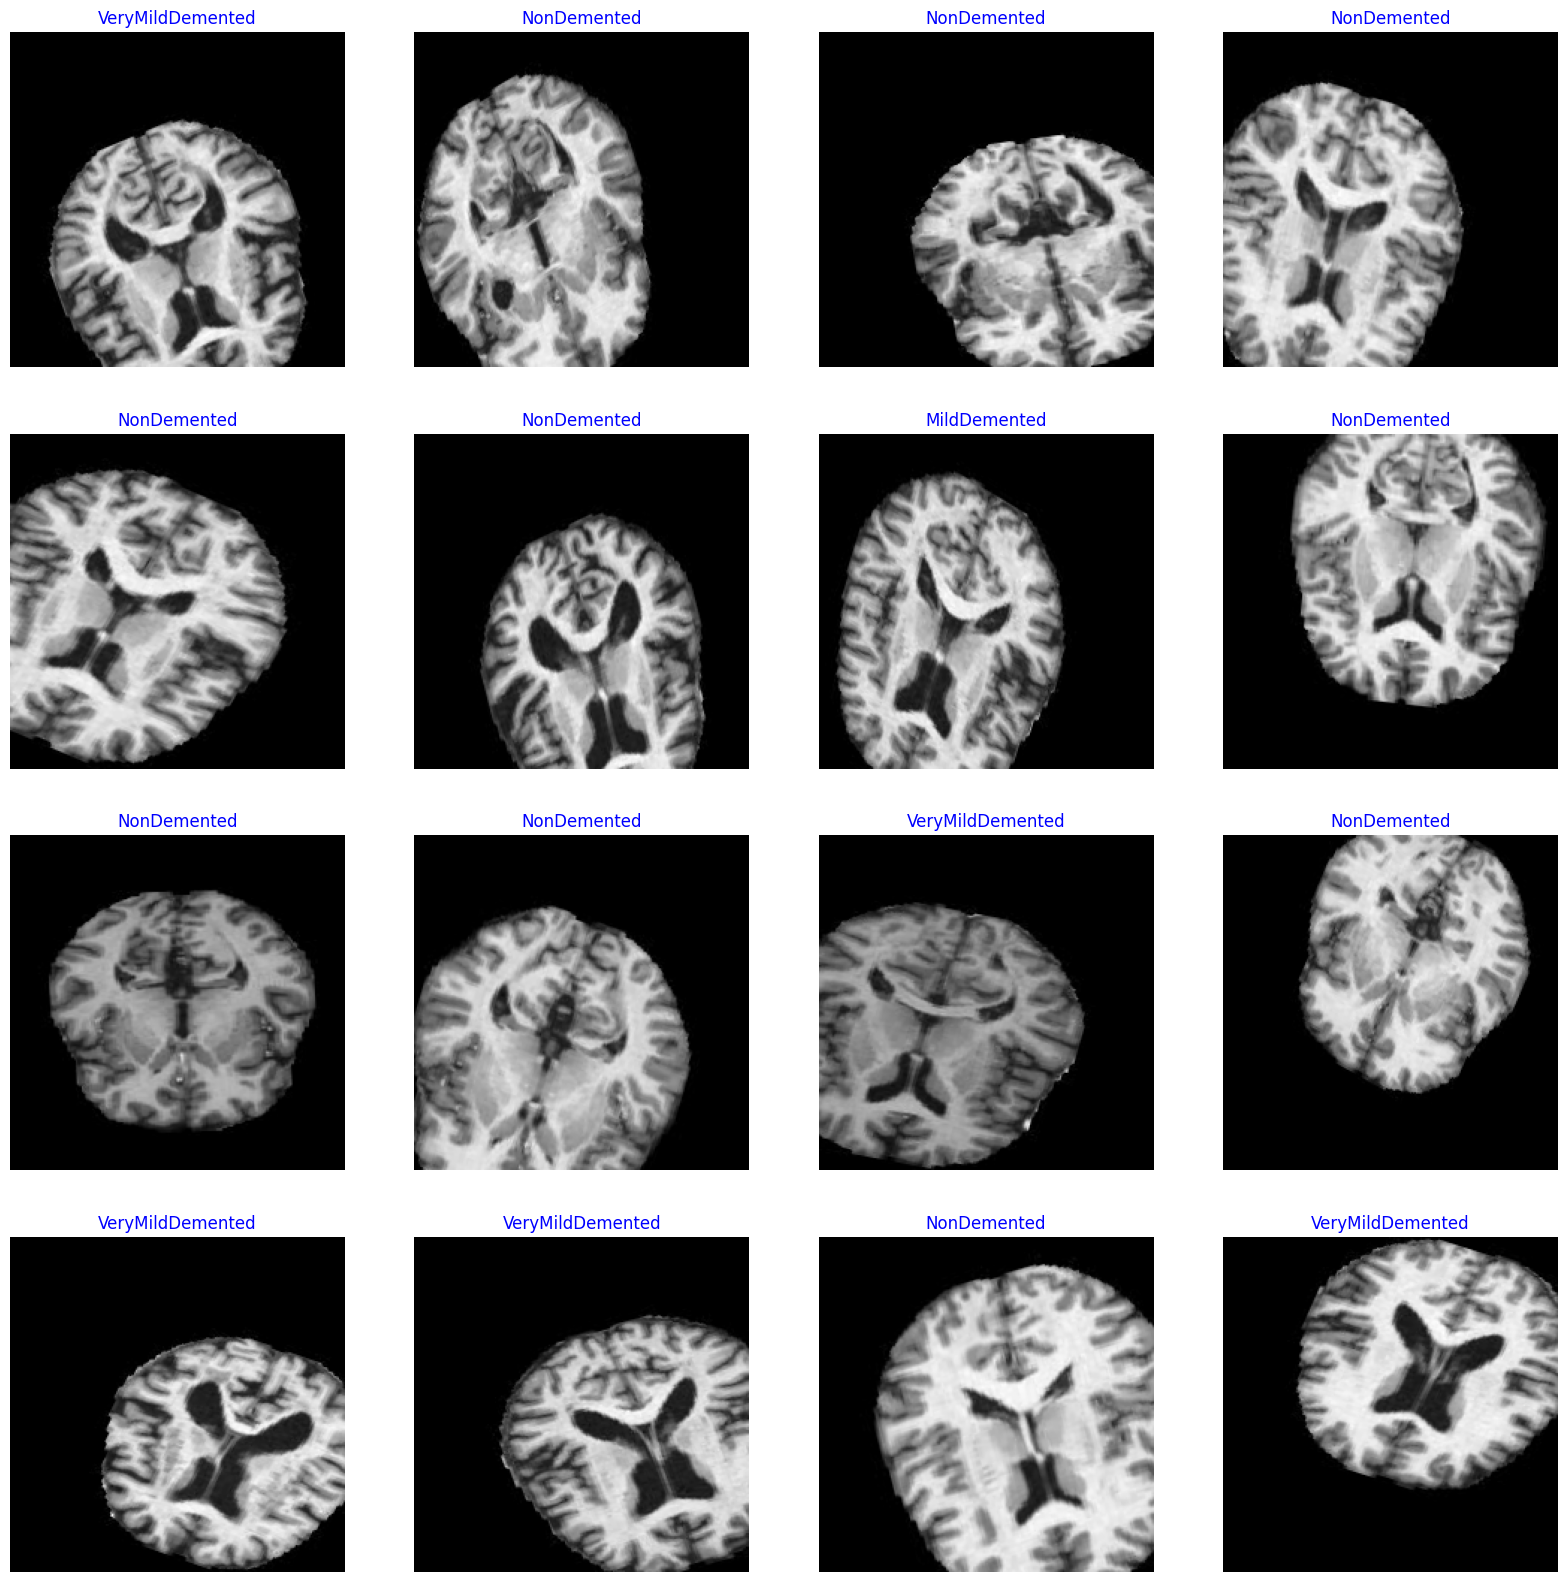

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] * 255       # scales data to range (0 - 255)
    plt.imshow(image.astype('uint8'))
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
    image = images[i] / 255
plt.show()

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 4
model =Sequential ([
    Conv2D(filters=64,kernel_size=(3,3),activation="relu",input_shape=img_shape),
    Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(filters=128,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=128,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),


    Conv2D(filters=256,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=256,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=256,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(256,activation="relu"),

    Dense(128,activation="relu"),
    Dense(4,activation="softmax")
])
model.compile (Adamax(learning_rate=0.001),loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 128)       0         
 g2D)                                                   

In [ ]:
epochs = 17  # number of all epochs in training

history = model.fit(train_gen , epochs= epochs , verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
321/321 [==============================] - 131s 390ms/step - loss: 1.0666 - accuracy: 0.4819 - val_loss: 1.0154 - val_accuracy: 0.5124
Epoch 2/10
321/321 [==============================] - 101s 315ms/step - loss: 1.0441 - accuracy: 0.4999 - val_loss: 1.0240 - val_accuracy: 0.5124
Epoch 3/10
321/321 [==============================] - 101s 313ms/step - loss: 1.0400 - accuracy: 0.4999 - val_loss: 1.0285 - val_accuracy: 0.5124
Epoch 4/10
321/321 [==============================] - 98s 304ms/step - loss: 1.0424 - accuracy: 0.4999 - val_loss: 1.0240 - val_accuracy: 0.5124
Epoch 5/10
321/321 [==============================] - 98s 304ms/step - loss: 1.0376 - accuracy: 0.4952 - val_loss: 1.0134 - val_accuracy: 0.5124
Epoch 6/10
321/321 [==============================] - 96s 300ms/step - loss: 1.0018 - accuracy: 0.5081 - val_loss: 0.9266 - val_accuracy: 0.5124
Epoch 7/10
321/321 [==============================] - 97s 302ms/step - loss: 0.9363 - accuracy: 0.5417 - val_loss: 0.9095 - val

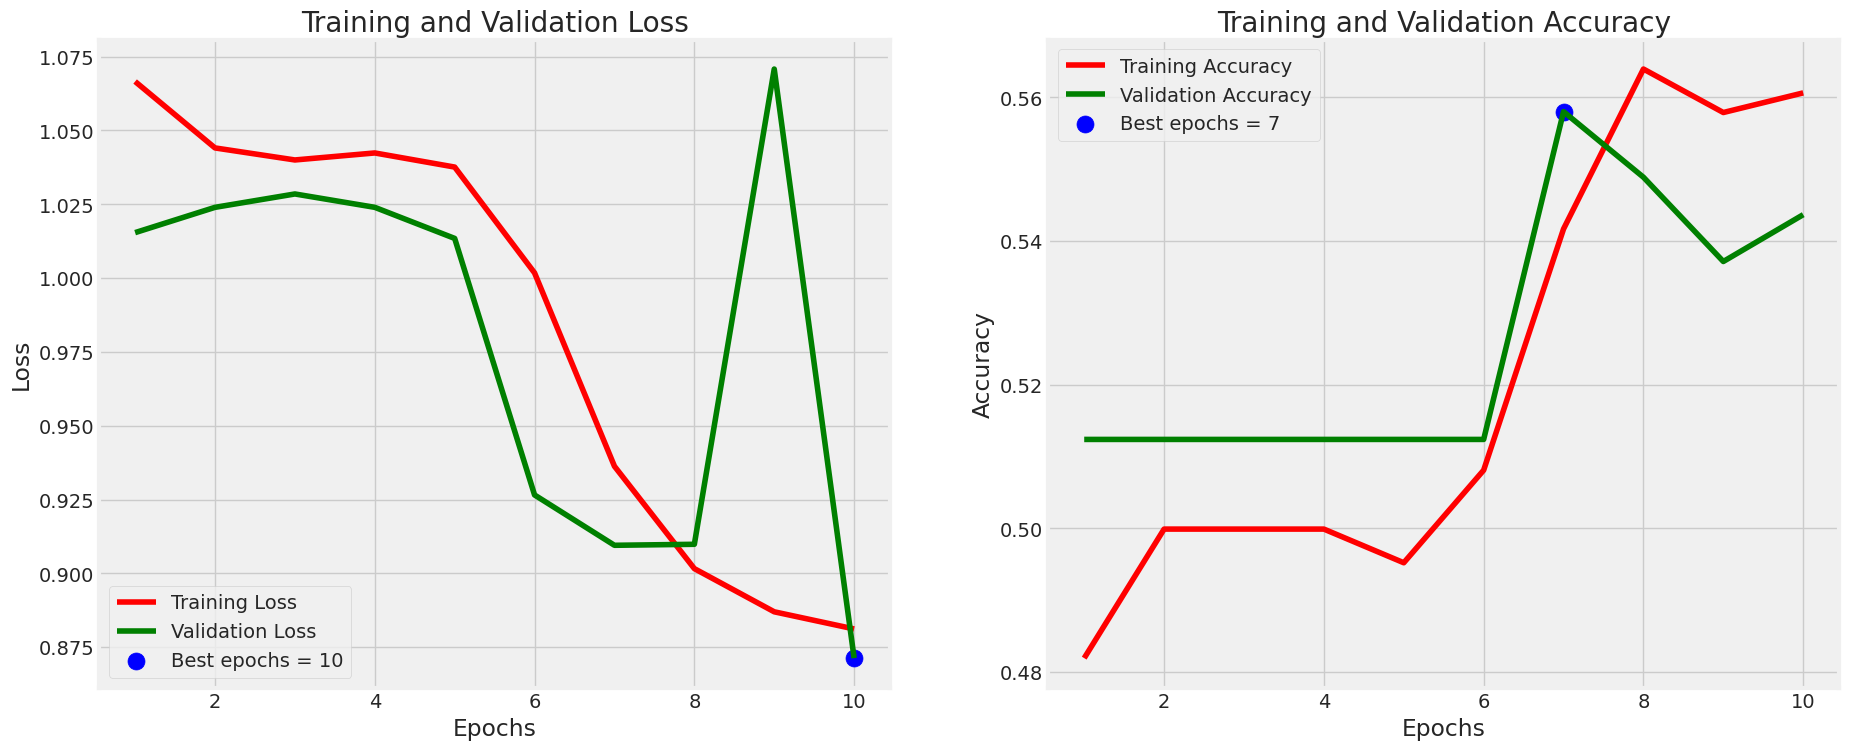

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [ ]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 1s 69ms/step - loss: 0.9105 - accuracy: 0.5273
Train Loss:  0.8652775287628174
Train Accuracy:  0.55078125
--------------------
Validation Loss:  0.8874284029006958
Validation Accuracy:  0.5390625
--------------------
Test Loss:  0.9105141758918762
Test Accuracy:  0.52734375


In [ ]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

32/32 [==============================] - 3s 84ms/step


In [ ]:
preds

array([[1.8598542e-01, 1.5880879e-02, 3.2973331e-01, 4.6840045e-01],
       [5.3118501e-04, 2.5630547e-07, 8.5991514e-01, 1.3955344e-01],
       [3.1070706e-01, 4.1763745e-02, 2.5816399e-01, 3.8936523e-01],
       ...,
       [2.2963136e-03, 5.6541362e-06, 8.1749898e-01, 1.8019907e-01],
       [3.0745050e-01, 4.5962363e-02, 2.6171637e-01, 3.8487080e-01],
       [1.7533122e-01, 1.2011609e-02, 3.3496562e-01, 4.7769153e-01]],
      dtype=float32)

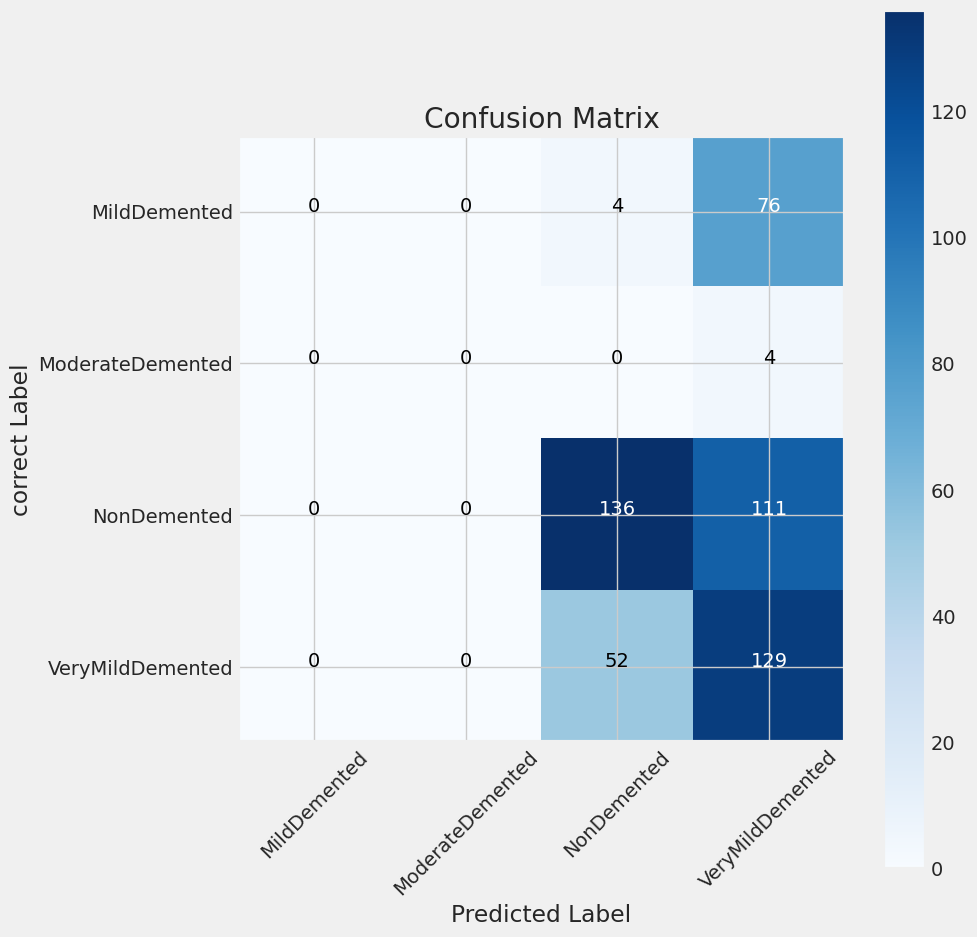

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('correct Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00        80
ModerateDemented       0.00      0.00      0.00         4
     NonDemented       0.71      0.55      0.62       247
VeryMildDemented       0.40      0.71      0.51       181

        accuracy                           0.52       512
       macro avg       0.28      0.32      0.28       512
    weighted avg       0.48      0.52      0.48       512

